# 사전학습된 VGG16

# 4번_분홍초록 전체 데이터

In [1]:
# 1-1-1

## batch_size=16, epochs=30, learning rate=0.0001(네번째자리)

## (1) 라이브러리 및 데이터 불러오기

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import vgg16
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import numpy as np
import cv2
import os
import glob
from PIL import Image
import random

In [3]:
import random

In [48]:
# 1번: warm_1 238 + cool_1 238 = 476
# 2번: warm_1 238 + warm_2 336 + cool_1 238 + cool_2 336 = 1148
# 3번: warm_1 740 + cool_1 238 = 978
# 4번: warm_1 740 + cool_1 238 + warm_2 2307 + cool_2 336 = 3621

def load_data(img_path, number_of_data=978):  
    # 웜톤 : 0, 쿨톤 : 1
    img_size=224
    color=3
    #이미지 데이터와 라벨(웜톤 : 0, 쿨톤 : 1) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0    
    
    warm1_files = list(glob.iglob(img_path + '/warm_1/*.jpg')) + list(glob.iglob(img_path + '/warm_1/*.JPG'))
#     warm2_files = list(glob.iglob(img_path + '/warm_2/*.jpg')) + list(glob.iglob(img_path + '/warm_2/*.JPG'))

    # 각 디렉토리에서 무작위로 선택
    warm1_files = random.sample(warm1_files, 740)
#     warm2_files = random.sample(warm2_files, 336)

    # 두 리스트를 합침
    warm_files = warm1_files 
#     + warm2_files

    for file in warm_files:
        img = Image.open(file)  # 이미지 열기
        img = img.resize((img_size, img_size))  # 이미지 크기 조정
        img = np.array(img, dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 웜톤 : 0
        idx=idx+1

                
    cool_files = (list(glob.iglob(img_path + '/cool_1/*.jpg')) + list(glob.iglob(img_path + '/cool_1/*.JPG')))
#               + list(glob.iglob(img_path + '/cool_2/*.jpg')) + list(glob.iglob(img_path + '/cool_2/*.JPG')))
    
    for file in cool_files:
        img = Image.open(file)  # 이미지 열기
        img = img.resize((img_size, img_size))  # 이미지 크기 조정
        img = np.array(img, dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 쿨톤 : 1
        idx=idx+1  
    
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/project/first-repository/data/DataSet_final/content/drive/MyDrive/사계절_연예인 이미지 데이터셋/train data"
(x_train, y_train)=load_data(image_dir_path)

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 978 입니다.
x_train shape: (978, 224, 224, 3)
y_train shape: (978,)


## (2) 정규화

In [49]:
x_train = x_train / 255.0

## (3) train, val 분리하기

In [50]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.3,
                                                  random_state=43)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (684, 224, 224, 3)
y_train:  (684,)
x_val:  (294, 224, 224, 3)
y_val:  (294,)


## (4) 모델 정의 및 컴파일

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [52]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기
vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
x = Dense(512, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=output)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [53]:
learning_rate = 0.0001

adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    './check/VGG16(사전학습)/3번/1-1/model_{epoch:02d}.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',    
)
# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## (5) 모델 학습하기

In [54]:
history = model.fit(x_train, y_train, batch_size=16, epochs=50, validation_data=(x_val, y_val),callbacks=[model_checkpoint_callback, early_stopping_callback])

Epoch 1/50
43/43 [==============================] - 19s 427ms/step - loss: 0.5485 - accuracy: 0.7471 - val_loss: 0.6647 - val_accuracy: 0.5612

Epoch 00001: val_loss improved from inf to 0.66470, saving model to ./check/VGG16(사전학습)/3번/1-1/model_01.h5
Epoch 2/50
43/43 [==============================] - 11s 255ms/step - loss: 0.3972 - accuracy: 0.8187 - val_loss: 0.3012 - val_accuracy: 0.8844

Epoch 00002: val_loss improved from 0.66470 to 0.30121, saving model to ./check/VGG16(사전학습)/3번/1-1/model_02.h5
Epoch 3/50
43/43 [==============================] - 11s 246ms/step - loss: 0.3964 - accuracy: 0.8246 - val_loss: 0.5219 - val_accuracy: 0.7857

Epoch 00003: val_loss did not improve from 0.30121
Epoch 4/50
43/43 [==============================] - 10s 242ms/step - loss: 0.3452 - accuracy: 0.8392 - val_loss: 0.4053 - val_accuracy: 0.8299

Epoch 00004: val_loss did not improve from 0.30121
Epoch 5/50
43/43 [==============================] - 10s 242ms/step - loss: 0.2973 - accuracy: 0.8670 - v

## (6) 예측하기

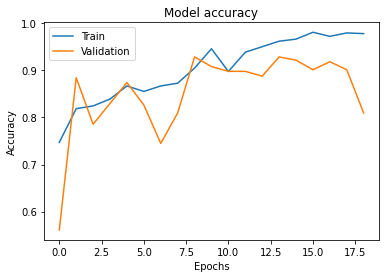

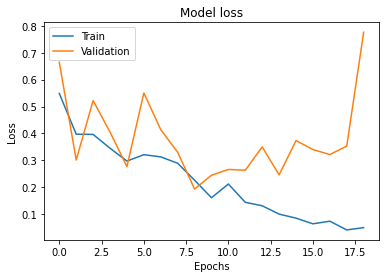

In [56]:
import matplotlib.pyplot as plt

# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [57]:
# checkpoint로 저장한 모델 불러올 때
from tensorflow.keras.models import load_model

# 체크포인트 파일의 경로를 지정합니다.
checkpoint_filepath = './check/VGG16(사전학습)/3번/1-1/model_09.h5'

# 체크포인트에 저장된 모델을 로드합니다.
model = load_model(checkpoint_filepath)

pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

In [58]:
print(pred_class)
print(y_val)
print(pred)

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0
 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 0
 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0
 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0
 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0
 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 1]
[1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0
 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 0
 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0
 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0
 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0

In [59]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.928571


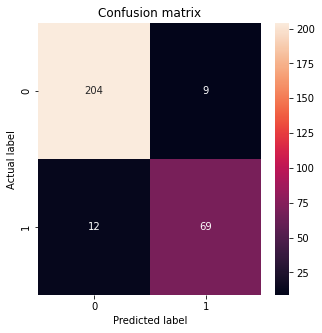

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## loss, accuracy 시각화

## confusion_matrix

## classification_report

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       923
           1       0.97      0.87      0.92       164

    accuracy                           0.98      1087
   macro avg       0.98      0.93      0.95      1087
weighted avg       0.98      0.98      0.98      1087



In [ ]:
# 수정본~

In [11]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기
vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
x = Dense(1024, activation='relu')(x)
x = Dense(514, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=output)
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [12]:
learning_rate = 0.0001

adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    './check/VGG16(사전학습)/4번/2-1/model_{epoch:02d}.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',    
)
# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [13]:
history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val),callbacks=[model_checkpoint_callback, early_stopping_callback])

Epoch 1/50
80/80 [==============================] - 46s 504ms/step - loss: 0.4310 - accuracy: 0.8382 - val_loss: 0.3663 - val_accuracy: 0.8491

Epoch 00001: val_loss improved from inf to 0.36629, saving model to ./check/VGG16(사전학습)/4번/2-1/model_01.h5
Epoch 2/50
80/80 [==============================] - 36s 456ms/step - loss: 0.3317 - accuracy: 0.8658 - val_loss: 0.3939 - val_accuracy: 0.8638

Epoch 00002: val_loss did not improve from 0.36629
Epoch 3/50
80/80 [==============================] - 37s 462ms/step - loss: 0.2728 - accuracy: 0.8938 - val_loss: 0.2486 - val_accuracy: 0.9108

Epoch 00003: val_loss improved from 0.36629 to 0.24859, saving model to ./check/VGG16(사전학습)/4번/2-1/model_03.h5
Epoch 4/50
80/80 [==============================] - 37s 458ms/step - loss: 0.2284 - accuracy: 0.9104 - val_loss: 0.1869 - val_accuracy: 0.9264

Epoch 00004: val_loss improved from 0.24859 to 0.18693, saving model to ./check/VGG16(사전학습)/4번/2-1/model_04.h5
Epoch 5/50
80/80 [==========================

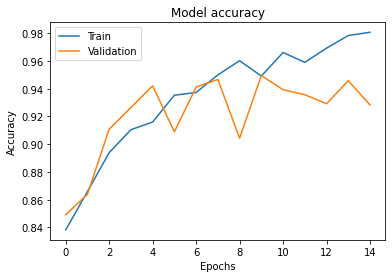

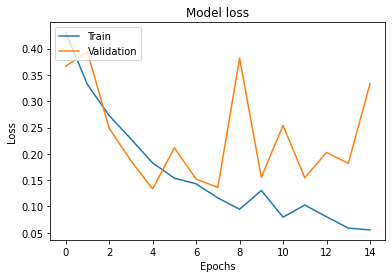

In [14]:
import matplotlib.pyplot as plt

# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

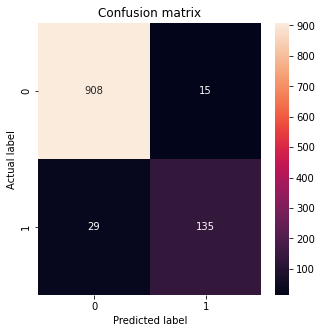

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [8]:
# checkpoint로 저장한 모델 불러올 때
from tensorflow.keras.models import load_model

# 체크포인트 파일의 경로를 지정합니다.
checkpoint_filepath = './check/VGG16(사전학습)/4번/2-1/model_10.h5'

# 체크포인트에 저장된 모델을 로드합니다.
model = load_model(checkpoint_filepath)

pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

In [9]:
print(pred_class)
print(y_val)
print(pred)

acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

[0 0 0 ... 1 0 0]
[0 0 0 ... 1 0 0]
[[9.4225872e-01 5.7741262e-02]
 [9.9996221e-01 3.7784397e-05]
 [9.9945134e-01 5.4864498e-04]
 ...
 [2.4507712e-03 9.9754924e-01]
 [9.9998701e-01 1.3023649e-05]
 [7.5484198e-01 2.4515802e-01]]
accuracy: 0.959522


In [8]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기
vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
x = Dense(1024, activation='relu')(x)
x = Dense(514, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
learning_rate = 0.0001

adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    './check/VGG16(사전학습)/4번/3-1/model_{epoch:02d}.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',    
)
# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [10]:
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val),callbacks=[model_checkpoint_callback, early_stopping_callback])

Epoch 1/50
40/40 [==============================] - 79s 1s/step - loss: 0.4616 - accuracy: 0.8382 - val_loss: 0.4238 - val_accuracy: 0.8491

Epoch 00001: val_loss improved from inf to 0.42379, saving model to ./check/VGG16(사전학습)/4번/3-1/model_01.h5
Epoch 2/50
40/40 [==============================] - 36s 893ms/step - loss: 0.4444 - accuracy: 0.8382 - val_loss: 0.4216 - val_accuracy: 0.8491

Epoch 00002: val_loss improved from 0.42379 to 0.42155, saving model to ./check/VGG16(사전학습)/4번/3-1/model_02.h5
Epoch 3/50
40/40 [==============================] - 37s 917ms/step - loss: 0.4203 - accuracy: 0.8382 - val_loss: 0.3981 - val_accuracy: 0.8491

Epoch 00003: val_loss improved from 0.42155 to 0.39805, saving model to ./check/VGG16(사전학습)/4번/3-1/model_03.h5
Epoch 4/50
40/40 [==============================] - 36s 912ms/step - loss: 0.3084 - accuracy: 0.8706 - val_loss: 0.1959 - val_accuracy: 0.9163

Epoch 00004: val_loss improved from 0.39805 to 0.19588, saving model to ./check/VGG16(사전학습)/4번/3-1

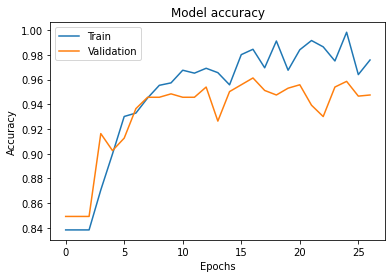

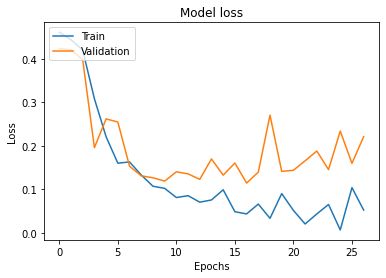

In [11]:
import matplotlib.pyplot as plt

# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
# checkpoint로 저장한 모델 불러올 때
from tensorflow.keras.models import load_model

# 체크포인트 파일의 경로를 지정합니다.
checkpoint_filepath = './check/VGG16(사전학습)/4번/3-1/model_17.h5'

# 체크포인트에 저장된 모델을 로드합니다.
model = load_model(checkpoint_filepath)

pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

In [16]:
print(pred_class)
print(y_val)
print(pred)

acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

[0 0 0 ... 1 1 0]
[0 0 0 ... 1 0 0]
[[9.9999523e-01 4.7500030e-06]
 [9.9999881e-01 1.2384352e-06]
 [7.6634592e-01 2.3365411e-01]
 ...
 [3.6737425e-04 9.9963260e-01]
 [4.8224840e-01 5.1775163e-01]
 [9.9999928e-01 7.4979948e-07]]
accuracy: 0.961362


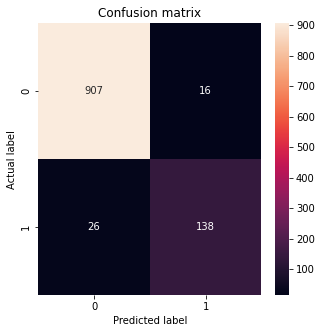

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# 1-1-2

## 정규화, random_state=42, batch_size=16, epochs=50, learning rate=0.0001(네번째자리),

## 데이터 바로 사용해도 되는지 확인

In [17]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (2534, 224, 224, 3)
y_train:  (2534,)
x_val:  (1087, 224, 224, 3)
y_val:  (1087,)


## (4) 모델 정의 및 컴파일

In [18]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기
vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
x = Dense(1024, activation='relu')(x)
x = Dense(514, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [19]:
learning_rate = 0.0001
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## (5) 모델 학습하기

In [ ]:
history = model.fit(x_train, y_train, batch_size=16, epochs=50, validation_data=(x_val, y_val))

## (6) 예측하기

In [ ]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

In [ ]:
print(pred_class)
print(y_val)
print(pred)

In [ ]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

## loss, accuracy 시각화

In [ ]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

In [ ]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [ ]:
print(classification_report(y_val, pred_class))

In [ ]:
## 1-2-1

## 정규화, random_state=42, batch_size=16, epochs=30, learning rate=0.00001(다섯번째자리),

## 데이터 바로 사용해도 되는지 확인

In [20]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (2534, 224, 224, 3)
y_train:  (2534,)
x_val:  (1087, 224, 224, 3)
y_val:  (1087,)


## (4) 모델 정의 및 컴파일

In [21]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기
vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
x = Dense(1024, activation='relu')(x)
x = Dense(514, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=output)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [22]:
learning_rate = 0.00001
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## (5) 모델 학습하기

In [23]:
history = model.fit(x_train, y_train, batch_size=16, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
159/159 [==============================] - 42s 258ms/step - loss: 0.3740 - accuracy: 0.8508 - val_loss: 0.3190 - val_accuracy: 0.8730
Epoch 2/30
159/159 [==============================] - 38s 240ms/step - loss: 0.2442 - accuracy: 0.9061 - val_loss: 0.2255 - val_accuracy: 0.9071
Epoch 3/30
159/159 [==============================] - 39s 243ms/step - loss: 0.1565 - accuracy: 0.9424 - val_loss: 0.2767 - val_accuracy: 0.9006
Epoch 4/30
159/159 [==============================] - 39s 243ms/step - loss: 0.1058 - accuracy: 0.9566 - val_loss: 0.3439 - val_accuracy: 0.9062
Epoch 5/30
159/159 [==============================] - 39s 243ms/step - loss: 0.0427 - accuracy: 0.9866 - val_loss: 0.2608 - val_accuracy: 0.9126
Epoch 6/30
159/159 [==============================] - 39s 243ms/step - loss: 0.0155 - accuracy: 0.9957 - val_loss: 0.4225 - val_accuracy: 0.9154
Epoch 7/30
159/159 [==============================] - 39s 242ms/step - loss: 0.0093 - accuracy: 0.9968 - val_loss: 0.3300 - val_ac

## (6) 예측하기

In [24]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

In [25]:
print(pred_class)
print(y_val)
print(pred)

[0 0 0 ... 1 0 0]
[0 0 0 ... 1 0 0]
[[1.0000000e+00 1.1776606e-12]
 [1.0000000e+00 2.8025795e-08]
 [1.0000000e+00 1.5480486e-10]
 ...
 [3.1154377e-07 9.9999964e-01]
 [1.0000000e+00 5.7148479e-17]
 [7.0063084e-01 2.9936919e-01]]


In [26]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.921803


## loss, accuracy 시각화

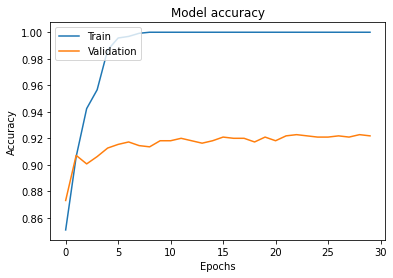

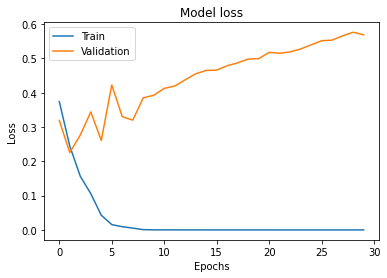

In [27]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

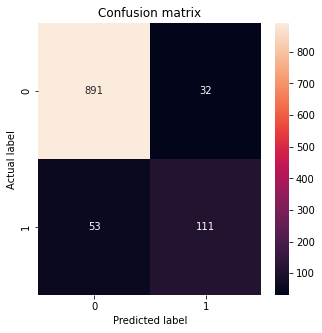

In [28]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [ ]:
print(classification_report(y_val, pred_class))

In [ ]:
# 1-2-2

## 정규화, random_state=42, batch_size=16, epochs=50, learning rate=0.00001(다섯번째자리),

## 데이터 바로 사용해도 되는지 확인

In [ ]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

## (4) 모델 정의 및 컴파일

In [ ]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기
vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
x = Dense(1024, activation='relu')(x)
x = Dense(514, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=output)
model.summary()

In [ ]:
learning_rate = 0.00001
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## (5) 모델 학습하기

In [ ]:
history = model.fit(x_train, y_train, batch_size=16, epochs=50, validation_data=(x_val, y_val))

## (6) 예측하기

In [ ]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

In [ ]:
print(pred_class)
print(y_val)
print(pred)

In [ ]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

## loss, accuracy 시각화

In [ ]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

In [ ]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [ ]:
print(classification_report(y_val, pred_class))

In [ ]:
# 1-3-1

## 정규화, random_state=42, batch_size=16, epochs=30, learning rate=0.000001(여섯번째자리),

## 데이터 바로 사용해도 되는지 확인

In [29]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (2534, 224, 224, 3)
y_train:  (2534,)
x_val:  (1087, 224, 224, 3)
y_val:  (1087,)


## (4) 모델 정의 및 컴파일

In [30]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기
vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
x = Dense(1024, activation='relu')(x)
x = Dense(514, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=output)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [31]:
learning_rate = 0.000001
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## (5) 모델 학습하기

In [32]:
history = model.fit(x_train, y_train, batch_size=16, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
159/159 [==============================] - 44s 258ms/step - loss: 0.4325 - accuracy: 0.8382 - val_loss: 0.3851 - val_accuracy: 0.8491
Epoch 2/30
159/159 [==============================] - 38s 242ms/step - loss: 0.3630 - accuracy: 0.8390 - val_loss: 0.3387 - val_accuracy: 0.8546
Epoch 3/30
159/159 [==============================] - 39s 244ms/step - loss: 0.2995 - accuracy: 0.8737 - val_loss: 0.3047 - val_accuracy: 0.8749
Epoch 4/30
159/159 [==============================] - 39s 243ms/step - loss: 0.2479 - accuracy: 0.9049 - val_loss: 0.2764 - val_accuracy: 0.8960
Epoch 5/30
159/159 [==============================] - 39s 243ms/step - loss: 0.2083 - accuracy: 0.9242 - val_loss: 0.2587 - val_accuracy: 0.8988
Epoch 6/30
159/159 [==============================] - 39s 243ms/step - loss: 0.1757 - accuracy: 0.9376 - val_loss: 0.2546 - val_accuracy: 0.8951
Epoch 7/30
159/159 [==============================] - 39s 243ms/step - loss: 0.1446 - accuracy: 0.9550 - val_loss: 0.2364 - val_ac

## (6) 예측하기

In [ ]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

In [ ]:
print(pred_class)
print(y_val)
print(pred)

In [ ]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

## loss, accuracy 시각화

In [ ]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

In [ ]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [ ]:
print(classification_report(y_val, pred_class))

In [ ]:
# 1-3-2

## 정규화, random_state=42, batch_size=16, epochs=50, learning rate=0.000001(여섯번째자리),

## 데이터 바로 사용해도 되는지 확인

In [ ]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

## (4) 모델 정의 및 컴파일

In [ ]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기
vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
x = Dense(1024, activation='relu')(x)
x = Dense(514, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=output)
model.summary()

In [ ]:
learning_rate = 0.000001
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## (5) 모델 학습하기

In [ ]:
history = model.fit(x_train, y_train, batch_size=16, epochs=50, validation_data=(x_val, y_val))

## (6) 예측하기

In [ ]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

In [ ]:
print(pred_class)
print(y_val)
print(pred)

In [ ]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

## loss, accuracy 시각화

In [ ]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

In [ ]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [ ]:
print(classification_report(y_val, pred_class))

In [ ]:
# 2-1-1

## 정규화, random_state=42, batch_size=32, epochs=30, learning rate=0.0001(네번째자리),

## 데이터 바로 사용해도 되는지 확인

In [9]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (2534, 224, 224, 3)
y_train:  (2534,)
x_val:  (1087, 224, 224, 3)
y_val:  (1087,)


## (4) 모델 정의 및 컴파일

In [10]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기
vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
x = Dense(1024, activation='relu')(x)
x = Dense(514, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
learning_rate = 0.0001
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# early stopping
from keras.callbacks import EarlyStopping


# EarlyStopping 객체를 생성합니다.
# 'val_loss'를 모니터링하고, 3 epoch 동안 성능 향상이 없으면 학습을 중단합니다.
early_stopping = EarlyStopping(monitor='val_loss', patience=3)


# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
# 여기부터 실행

## (5) 모델 학습하기

In [12]:
history = model.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/30
80/80 [==============================] - 98s 582ms/step - loss: 0.4509 - accuracy: 0.8339 - val_loss: 0.4373 - val_accuracy: 0.8491
Epoch 2/30
80/80 [==============================] - 36s 456ms/step - loss: 0.4307 - accuracy: 0.8382 - val_loss: 0.4274 - val_accuracy: 0.8491
Epoch 3/30
80/80 [==============================] - 37s 459ms/step - loss: 0.4488 - accuracy: 0.8382 - val_loss: 0.4292 - val_accuracy: 0.8491
Epoch 4/30
80/80 [==============================] - 36s 455ms/step - loss: 0.4475 - accuracy: 0.8382 - val_loss: 0.4316 - val_accuracy: 0.8491
Epoch 5/30
80/80 [==============================] - 36s 457ms/step - loss: 0.4331 - accuracy: 0.8382 - val_loss: 0.4011 - val_accuracy: 0.8482
Epoch 6/30
80/80 [==============================] - 36s 457ms/step - loss: 0.3169 - accuracy: 0.8678 - val_loss: 0.2778 - val_accuracy: 0.8868
Epoch 7/30
80/80 [==============================] - 37s 459ms/step - loss: 0.2422 - accuracy: 0.8994 - val_loss: 0.2224 - val_accuracy: 0.9071

## (6) 예측하기

In [13]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

In [14]:
print(pred_class)
print(y_val)
print(pred)

[0 0 0 ... 1 0 0]
[0 0 0 ... 1 0 0]
[[9.4095528e-01 5.9044667e-02]
 [9.9994969e-01 5.0335122e-05]
 [9.9999642e-01 3.5953631e-06]
 ...
 [1.2102814e-02 9.8789716e-01]
 [9.7987980e-01 2.0120228e-02]
 [9.9932134e-01 6.7867542e-04]]


In [15]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.885925


## loss, accuracy 시각화

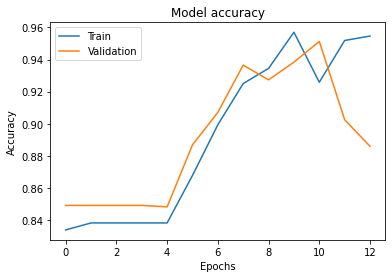

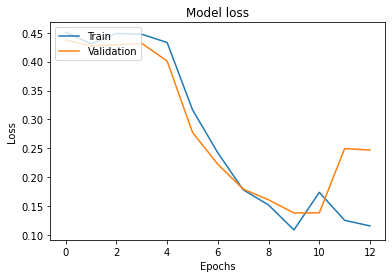

In [18]:


# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

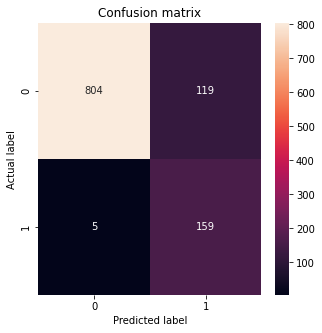

In [22]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [ ]:
print(classification_report(y_val, pred_class))

In [ ]:
# 2-1-2

## 정규화, random_state=42, batch_size=32, epochs=50, learning rate=0.0001(네번째자리),

## 데이터 바로 사용해도 되는지 확인

In [ ]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

## (4) 모델 정의 및 컴파일

In [ ]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기
vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
x = Dense(1024, activation='relu')(x)
x = Dense(514, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=output)
model.summary()

In [ ]:
learning_rate = 0.0001
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## (5) 모델 학습하기

In [ ]:
history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val))

## (6) 예측하기

In [ ]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

In [ ]:
print(pred_class)
print(y_val)
print(pred)

In [ ]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

## loss, accuracy 시각화

In [ ]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

In [ ]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [ ]:
print(classification_report(y_val, pred_class))

In [ ]:
# 2-2-1

## 정규화, random_state=42, batch_size=32, epochs=30, learning rate=0.00001(다섯번째자리),

## 데이터 바로 사용해도 되는지 확인

In [ ]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

## (4) 모델 정의 및 컴파일

In [ ]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기
vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
x = Dense(1024, activation='relu')(x)
x = Dense(514, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=output)
model.summary()

In [ ]:
learning_rate = 0.00001
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## (5) 모델 학습하기

In [ ]:
history = model.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val, y_val))

## (6) 예측하기

In [ ]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

In [ ]:
print(pred_class)
print(y_val)
print(pred)

In [ ]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

## loss, accuracy 시각화

In [ ]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

In [ ]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [ ]:
print(classification_report(y_val, pred_class))

In [ ]:
# 2-2-2

## 정규화, random_state=42, batch_size=32, epochs=50, learning rate=0.00001(다섯번째자리),

## 데이터 바로 사용해도 되는지 확인

In [ ]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

## (4) 모델 정의 및 컴파일

In [ ]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기
vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
x = Dense(1024, activation='relu')(x)
x = Dense(514, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=output)
model.summary()

In [ ]:
learning_rate = 0.00001
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## (5) 모델 학습하기

In [ ]:
history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val))

## (6) 예측하기

In [ ]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

In [ ]:
print(pred_class)
print(y_val)
print(pred)

In [ ]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

## loss, accuracy 시각화

In [ ]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

In [ ]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [ ]:
print(classification_report(y_val, pred_class))

In [ ]:
## 2-3-1

## 정규화, random_state=42, batch_size=32, epochs=30, learning rate=0.000001(여섯번째자리),

## 데이터 바로 사용해도 되는지 확인

In [ ]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

## (4) 모델 정의 및 컴파일

In [ ]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기
vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
x = Dense(1024, activation='relu')(x)
x = Dense(514, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=output)
model.summary()

In [ ]:
learning_rate = 0.000001
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## (5) 모델 학습하기

In [ ]:
history = model.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_val, y_val))

## (6) 예측하기

In [ ]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

In [ ]:
print(pred_class)
print(y_val)
print(pred)

In [ ]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

## loss, accuracy 시각화

In [ ]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

In [ ]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [ ]:
print(classification_report(y_val, pred_class))

In [ ]:
# 2-3-2

## 정규화, random_state=42, batch_size=32, epochs=50, learning rate=0.000001(여섯번째자리),

## 데이터 바로 사용해도 되는지 확인

In [ ]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

## (4) 모델 정의 및 컴파일

In [ ]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기
vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
x = Dense(1024, activation='relu')(x)
x = Dense(514, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=output)
model.summary()

In [ ]:
learning_rate = 0.000001
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## (5) 모델 학습하기

In [ ]:
history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val))

## (6) 예측하기

In [ ]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

In [ ]:
print(pred_class)
print(y_val)
print(pred)

In [ ]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

## loss, accuracy 시각화

In [ ]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

In [ ]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [ ]:
print(classification_report(y_val, pred_class))

In [ ]:
# 3-1-1

## 정규화, random_state=42, batch_size=64, epochs=30, learning rate=0.0001(네번째자리),

## 데이터 바로 사용해도 되는지 확인

In [ ]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

## (4) 모델 정의 및 컴파일

In [23]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기
vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
x = Dense(1024, activation='relu')(x)
x = Dense(514, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [24]:
learning_rate = 0.0001
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## (5) 모델 학습하기

In [25]:
history = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
40/40 [==============================] - 81s 2s/step - loss: 0.4527 - accuracy: 0.8228 - val_loss: 0.3280 - val_accuracy: 0.8703
Epoch 2/30
40/40 [==============================] - 36s 908ms/step - loss: 0.3075 - accuracy: 0.8745 - val_loss: 0.3525 - val_accuracy: 0.8712
Epoch 3/30
40/40 [==============================] - 36s 905ms/step - loss: 0.2374 - accuracy: 0.9069 - val_loss: 0.2294 - val_accuracy: 0.8997
Epoch 4/30
40/40 [==============================] - 36s 909ms/step - loss: 0.1978 - accuracy: 0.9238 - val_loss: 0.1906 - val_accuracy: 0.9273
Epoch 5/30
40/40 [==============================] - 36s 909ms/step - loss: 0.1472 - accuracy: 0.9369 - val_loss: 0.1759 - val_accuracy: 0.9273
Epoch 6/30
40/40 [==============================] - 36s 910ms/step - loss: 0.1516 - accuracy: 0.9298 - val_loss: 0.1540 - val_accuracy: 0.9393
Epoch 7/30
40/40 [==============================] - 36s 908ms/step - loss: 0.1332 - accuracy: 0.9428 - val_loss: 0.1367 - val_accuracy: 0.9411
Ep

## (6) 예측하기

In [26]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

In [27]:
print(pred_class)
print(y_val)
print(pred)

[0 0 0 ... 1 0 0]
[0 0 0 ... 1 0 0]
[[9.9999905e-01 1.0026068e-06]
 [1.0000000e+00 1.4181794e-13]
 [1.0000000e+00 2.9841552e-12]
 ...
 [6.5334343e-10 1.0000000e+00]
 [1.0000000e+00 2.3576474e-11]
 [1.0000000e+00 5.8893797e-09]]


In [ ]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

## loss, accuracy 시각화

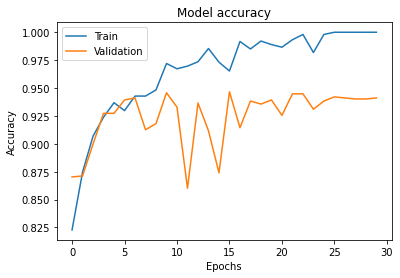

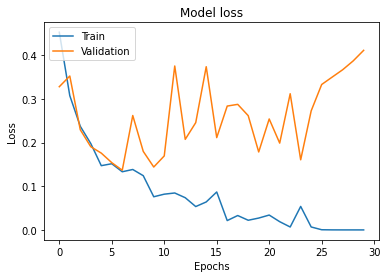

In [29]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

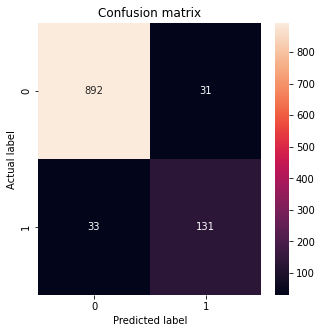

In [30]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_val, pred_class))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       923
           1       0.81      0.80      0.80       164

    accuracy                           0.94      1087
   macro avg       0.89      0.88      0.88      1087
weighted avg       0.94      0.94      0.94      1087



In [ ]:
# 3-1-2

## 정규화, random_state=42, batch_size=64, epochs=50, learning rate=0.0001(네번째자리),

## 데이터 바로 사용해도 되는지 확인

In [ ]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

## (4) 모델 정의 및 컴파일

In [ ]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기
vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
x = Dense(1024, activation='relu')(x)
x = Dense(514, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=output)
model.summary()

In [ ]:
learning_rate = 0.0001
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## (5) 모델 학습하기

In [ ]:
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val))

## (6) 예측하기

In [ ]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

In [ ]:
print(pred_class)
print(y_val)
print(pred)

In [ ]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

## loss, accuracy 시각화

In [ ]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

In [ ]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [ ]:
print(classification_report(y_val, pred_class))

In [ ]:
# 3-2-1

## 정규화, random_state=42, batch_size=64, epochs=30, learning rate=0.00001(다섯번째자리),

## 데이터 바로 사용해도 되는지 확인

In [ ]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

## (4) 모델 정의 및 컴파일

In [ ]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기
vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
x = Dense(1024, activation='relu')(x)
x = Dense(514, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=output)
model.summary()

In [ ]:
learning_rate = 0.00001
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## (5) 모델 학습하기

In [ ]:
history = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_val, y_val))

## (6) 예측하기

In [ ]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

In [ ]:
print(pred_class)
print(y_val)
print(pred)

In [ ]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

## loss, accuracy 시각화

In [ ]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

In [ ]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [ ]:
print(classification_report(y_val, pred_class))

In [ ]:
# 3-2-2

## 정규화, random_state=42, batch_size=64, epochs=50, learning rate=0.00001(다섯번째자리),

## 데이터 바로 사용해도 되는지 확인

In [ ]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

## (4) 모델 정의 및 컴파일

In [ ]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기
vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
x = Dense(1024, activation='relu')(x)
x = Dense(514, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=output)
model.summary()

In [ ]:
learning_rate = 0.00001
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## (5) 모델 학습하기

In [ ]:
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val))

## (6) 예측하기

In [ ]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

In [ ]:
print(pred_class)
print(y_val)
print(pred)

In [ ]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

## loss, accuracy 시각화

In [ ]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

In [ ]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [ ]:
print(classification_report(y_val, pred_class))

In [ ]:
# 3-3-1

## 정규화, random_state=42, batch_size=64, epochs=30, learning rate=0.000001(여섯번째자리),

## 데이터 바로 사용해도 되는지 확인

In [ ]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

## (4) 모델 정의 및 컴파일

In [ ]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기
vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
x = Dense(1024, activation='relu')(x)
x = Dense(514, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=output)
model.summary()

In [ ]:
learning_rate = 0.000001
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## (5) 모델 학습하기

In [ ]:
history = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_val, y_val))

## (6) 예측하기

In [ ]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

In [ ]:
print(pred_class)
print(y_val)
print(pred)

In [ ]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

## loss, accuracy 시각화

In [ ]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

In [ ]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [ ]:
print(classification_report(y_val, pred_class))

In [ ]:
# 3-3-2

## 정규화, random_state=42, batch_size=64, epochs=50, learning rate=0.000001(여섯번째자리),

## 데이터 바로 사용해도 되는지 확인

In [ ]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

## (4) 모델 정의 및 컴파일

In [ ]:
from tensorflow.keras.applications import VGG16

# VGG16 모델 가져오기
vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
x = Dense(1024, activation='relu')(x)
x = Dense(514, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# 새로운 모델 정의
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=output)
model.summary()

In [ ]:
learning_rate = 0.000001
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## (5) 모델 학습하기

In [ ]:
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val))

## (6) 예측하기

In [ ]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)

In [ ]:
print(pred_class)
print(y_val)
print(pred)

In [ ]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

## loss, accuracy 시각화

In [ ]:
# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## confusion_matrix

In [ ]:
# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## classification_report

In [ ]:
print(classification_report(y_val, pred_class))

In [ ]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint

# # EarlyStopping과 ModelCheckpoint 객체를 생성합니다.
# early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# # fit 함수를 호출할 때 callbacks 매개변수에 early_stopping과 model_checkpoint를 전달합니다.
# hist = model.fit(train_generator, epochs=30, validation_data=(x_val, y_val), callbacks=[early_stopping, model_checkpoint])